In [911]:
import numpy as np
import pandas as pd 
import os 
import shutil 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import random
import uuid

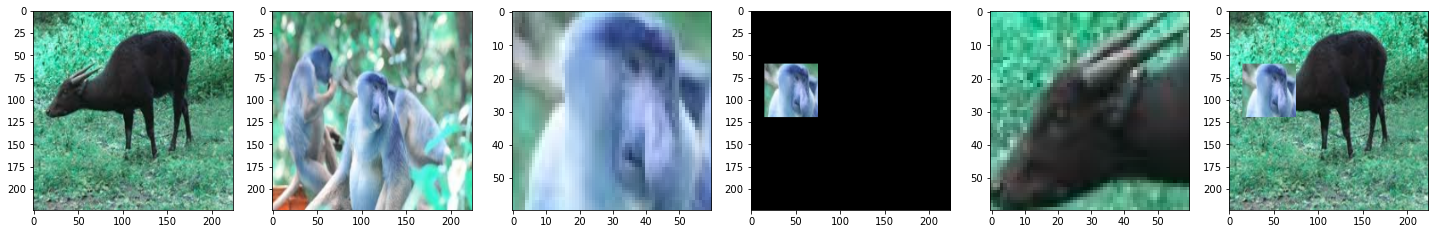

In [363]:
# CutMix
IMG_SIZE= 224 
f = plt.figure(figsize=(25,25))
# plt.subplot(2,2,1)
f.add_subplot(2,6,1)
image_1 = cv2.imread('static/img/dataset/test/anoa/0d9f3f1371.jpg')
image_1 = cv2.resize(image_1,(IMG_SIZE,IMG_SIZE))
plt.imshow(image_1)

# plt.subplot(2,2,2)
f.add_subplot(2,6,2)
image_2 = cv2.imread('static/img/dataset/test/bekantan/dbc397833c.jpg')
image_2 = cv2.resize(image_2,(IMG_SIZE,IMG_SIZE))
plt.imshow(image_2)

f.add_subplot(2,6,3)
image_3 = cv2.imread('static/img/dataset/test/bekantan/dbc397833c.jpg')
image_3 = cv2.resize(image_3,(IMG_SIZE,IMG_SIZE))
crop_1 = tf.image.crop_to_bounding_box(image_3,70,80,60,60)
plt.imshow(crop_1)

f.add_subplot(2,6,4)
image_4 = tf.image.pad_to_bounding_box(crop_1,60,15,IMG_SIZE,IMG_SIZE)
plt.imshow(image_4)

f.add_subplot(2,6,5)
image_5 = cv2.imread('static/img/dataset/test/anoa/0d9f3f1371.jpg')
image_5 = cv2.resize(image_5,(IMG_SIZE,IMG_SIZE))
crop_2 = tf.image.crop_to_bounding_box(image_5,60,15,60,60)
plt.imshow(crop_2)

f.add_subplot(2,6,6)
image_6 = tf.image.pad_to_bounding_box(crop_2,60,15,IMG_SIZE,IMG_SIZE)
plt.imshow(image_1-image_6+image_4)

## CutMix

In [1217]:
import tensorflow_probability as tfp

def box_cutmix(lamda):
    IMG_SIZE= 224 
    r_x = tf.cast(tfp.distributions.Uniform(30,IMG_SIZE).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(30,IMG_SIZE).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IMG_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)
    r_h = tf.cast(IMG_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2,0,IMG_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2,0,IMG_SIZE)

    x_br = tf.clip_by_value(r_x + r_w//2,0,IMG_SIZE)
    y_br = tf.clip_by_value(r_y + r_h//2,0,IMG_SIZE)

    r_w = x_br - r_x
    if r_w == 0:
        r_w = 25
    elif r_w < 25:
        r_w = 25
        
    r_h = y_br - r_y
    if r_h == 0:
        r_h = 25
    elif r_h < 25:
        r_h = 25

    return r_x,r_y,r_w,r_h


In [1218]:
def cutmix(src,dst,place):
    IMG_SIZE= 224 
    lamda = tfp.distributions.Beta(0.2,0.2)
    lamda = lamda.sample(1)[0]
    r_x,r_y,r_w,r_h = box_cutmix(lamda=0.1)
    
    image_1 = cv2.imread(dst)
    image_1 = cv2.resize(image_1,(IMG_SIZE,IMG_SIZE))
    crop_1 = tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
    image_isi = tf.image.pad_to_bounding_box(crop_1,r_y,r_x,IMG_SIZE,IMG_SIZE)
    
    image_2 = cv2.imread(src)
    image_2 = cv2.resize(image_2,(IMG_SIZE,IMG_SIZE))
    crop_2 = tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
    
    image_3 = tf.image.pad_to_bounding_box(crop_2,r_y,r_x,IMG_SIZE,IMG_SIZE)
    image_akhir = np.array(image_2-image_3+image_isi)
    cv2.imwrite(f'{place}/{str(uuid.uuid4())[:10]}.jpg',image_akhir)
    print('Download Success')
    # plt.imshow(cv2.cvtColor(image_akhir,cv2.COLOR_BGR2RGB))
    

## CutOut

In [1231]:
def box_cutout(lamda):
    IMG_SIZE= 224 
    r_x = tf.cast(tfp.distributions.Uniform(24,190).sample(1)[0], dtype=tf.int32)
    r_y = tf.cast(tfp.distributions.Uniform(0,190).sample(1)[0], dtype=tf.int32)

    r_w = tf.cast(IMG_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)
    r_h = tf.cast(IMG_SIZE*tf.math.sqrt(1-lamda), dtype=tf.int32)

    r_x = tf.clip_by_value(r_x - r_w//2,0,IMG_SIZE)
    r_y = tf.clip_by_value(r_y - r_h//2,0,IMG_SIZE)

    x_br = tf.clip_by_value(r_x + r_w//2,0,IMG_SIZE)
    y_br = tf.clip_by_value(r_y + r_h//2,0,IMG_SIZE)

    r_w = x_br - r_x
    if r_w == 0:
        r_w = 30
    elif r_w < 30:
        r_w = 30
        
    r_h = y_br - r_y
    if r_h == 0:
        r_h = 30
    elif r_h < 30:
        r_h = 30
    return r_x,r_y,r_w,r_h

In [1232]:
def cutout(src,place):
    
    lamda = tfp.distributions.Beta(0.25,0.25)
    lamda = lamda.sample(1)[0]
    IMG_SIZE= 224 
    r_x,r_y,r_w,r_h = box_cutout(lamda)
    
    image_1 = cv2.imread(src)
    image_1 = cv2.resize(image_1,(IMG_SIZE,IMG_SIZE))
    crop_1 = tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
    
    image_2 = tf.image.pad_to_bounding_box(crop_1,r_y,r_x,IMG_SIZE,IMG_SIZE)
    
    image_akhir = np.array(image_1 - image_2)
    
    cv2.imwrite(f'{place}/{str(uuid.uuid4())[:10]}.jpg',image_akhir)
    # plt.imshow(cv2.cvtColor(image_akhir,cv2.COLOR_BGR2RGB))

## MixUp

In [1273]:
def mixup(x1, x2, place, lambda_=0.58):
    IMG_SIZE = 224
    src = cv2.imread(x1)
    src = cv2.resize(src,(IMG_SIZE,IMG_SIZE))
    
    dst = cv2.imread(x2)
    dst = cv2.resize(dst,(IMG_SIZE,IMG_SIZE))
    
    x = lambda_ * src + (1 - lambda_) * dst
    cv2.imwrite(f'{place}/{str(uuid.uuid4())[:10]}.jpg',x)
    
    # plt.imshow(x.astype(int))

## Percobaan

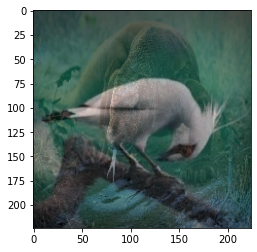

In [1268]:
mixup("static/img/dataset/train/jalak_bali/0ade192754.jpg", "static/img/dataset/train/komodo/5f083cda5a.jpg")

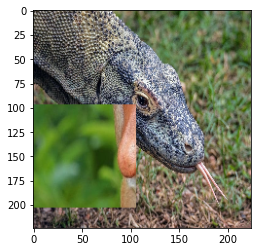

In [923]:
cutmix('static/img/dataset/test/bekantan/381248c581.jpg','static/img/dataset/test/komodo/6facb5c3d4.jpg','/')

In [1233]:
cutout("static/img/dataset/test/komodo/08cb032335.jpg",'dataset')

## Download Image

### Download For CutMix

In [972]:
L_BINATANG = ['anoa','komodo','jalak_bali','orang_utan','bekantan']
PATH_TRAIN_CUTMIX = os.path.join('static','img','dataset_cutmix','train')
L_IMG_CUTMIX_TRAIN_ANOA = os.listdir(os.path.join(PATH_TRAIN_CUTMIX,'anoa'))
L_IMG_CUTMIX_TRAIN_KOMODO = os.listdir(os.path.join(PATH_TRAIN_CUTMIX,'komodo'))
L_IMG_CUTMIX_TRAIN_JALAKBALI = os.listdir(os.path.join(PATH_TRAIN_CUTMIX,'jalak_bali'))
L_IMG_CUTMIX_TRAIN_ORANGUTAN = os.listdir(os.path.join(PATH_TRAIN_CUTMIX,'orang_utan'))
L_IMG_CUTMIX_TRAIN_BEKANTAN = os.listdir(os.path.join(PATH_TRAIN_CUTMIX,'bekantan'))

Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Success
Download Succe

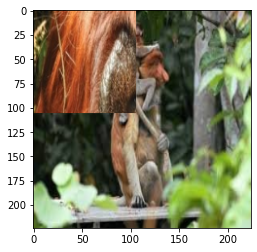

In [981]:
for j in L_BINATANG:
    place = os.path.join(PATH_TRAIN_CUTMIX,j)
    if j == 'anoa':
        lst_temp = L_IMG_CUTMIX_TRAIN_ANOA
    elif j == 'komodo':
        lst_temp = L_IMG_CUTMIX_TRAIN_KOMODO
    elif j == 'jalak_bali':
        lst_temp = L_IMG_CUTMIX_TRAIN_JALAKBALI
    elif j == 'orang_utan':
        lst_temp = L_IMG_CUTMIX_TRAIN_ORANGUTAN
    else:
        lst_temp = L_IMG_CUTMIX_TRAIN_BEKANTAN
    for i,name in enumerate(lst_temp):
        src = os.path.join(PATH_TRAIN_CUTMIX,j,name)
        dst = random.choice(L_BINATANG)
        while j == dst:
            dst = random.choice(L_BINATANG)
        if dst == 'anoa':
            dst_path = os.path.join(PATH_TRAIN_CUTMIX,dst,random.choice(L_IMG_CUTMIX_TRAIN_ANOA))
        elif dst == 'komodo':
            dst_path = os.path.join(PATH_TRAIN_CUTMIX,dst,random.choice(L_IMG_CUTMIX_TRAIN_KOMODO))
        elif dst == 'jalak_bali':
            dst_path = os.path.join(PATH_TRAIN_CUTMIX,dst,random.choice(L_IMG_CUTMIX_TRAIN_JALAKBALI))
        elif dst == 'orang_utan':
            dst_path = os.path.join(PATH_TRAIN_CUTMIX,dst,random.choice(L_IMG_CUTMIX_TRAIN_ORANGUTAN))
        else:
            dst_path = os.path.join(PATH_TRAIN_CUTMIX,dst,random.choice(L_IMG_CUTMIX_TRAIN_BEKANTAN))
        cutmix(src,dst_path,place)

### Download CutOut

In [1236]:
PATH_TRAIN_CUTOUT = os.path.join('static','img','dataset_cutout','train')
L_IMG_CUTOUT_TRAIN_ANOA = os.listdir(os.path.join(PATH_TRAIN_CUTOUT,'anoa'))
L_IMG_CUTOUT_TRAIN_KOMODO = os.listdir(os.path.join(PATH_TRAIN_CUTOUT,'komodo'))
L_IMG_CUTOUT_TRAIN_JALAKBALI = os.listdir(os.path.join(PATH_TRAIN_CUTOUT,'jalak_bali'))
L_IMG_CUTOUT_TRAIN_ORANGUTAN = os.listdir(os.path.join(PATH_TRAIN_CUTOUT,'orang_utan'))
L_IMG_CUTOUT_TRAIN_BEKANTAN = os.listdir(os.path.join(PATH_TRAIN_CUTOUT,'bekantan'))

In [1237]:
for j in L_BINATANG:
    place = os.path.join(PATH_TRAIN_CUTOUT,j)
    if j == 'anoa':
        lst_temp = L_IMG_CUTOUT_TRAIN_ANOA
    elif j == 'komodo':
        lst_temp = L_IMG_CUTOUT_TRAIN_KOMODO
    elif j == 'jalak_bali':
        lst_temp = L_IMG_CUTOUT_TRAIN_JALAKBALI
    elif j == 'orang_utan':
        lst_temp = L_IMG_CUTOUT_TRAIN_ORANGUTAN
    else:
        lst_temp = L_IMG_CUTOUT_TRAIN_BEKANTAN
    for i,name in enumerate(lst_temp):
        src = os.path.join(PATH_TRAIN_CUTMIX,j,name)
        cutout(src,place)

### Donwload MixUp

In [1270]:
PATH_TRAIN_MIXUP = os.path.join('static','img','dataset_mixup','train')
L_IMG_MIXUP_TRAIN_ANOA = os.listdir(os.path.join(PATH_TRAIN_MIXUP,'anoa'))
L_IMG_MIXUP_TRAIN_KOMODO = os.listdir(os.path.join(PATH_TRAIN_MIXUP,'komodo'))
L_IMG_MIXUP_TRAIN_JALAKBALI = os.listdir(os.path.join(PATH_TRAIN_MIXUP,'jalak_bali'))
L_IMG_MIXUP_TRAIN_ORANGUTAN = os.listdir(os.path.join(PATH_TRAIN_MIXUP,'orang_utan'))
L_IMG_MIXUP_TRAIN_BEKANTAN = os.listdir(os.path.join(PATH_TRAIN_MIXUP,'bekantan'))

In [1275]:
for j in L_BINATANG:
    place = os.path.join(PATH_TRAIN_MIXUP,j)
    if j == 'anoa':
        lst_temp = L_IMG_MIXUP_TRAIN_ANOA
    elif j == 'komodo':
        lst_temp = L_IMG_MIXUP_TRAIN_KOMODO
    elif j == 'jalak_bali':
        lst_temp = L_IMG_MIXUP_TRAIN_JALAKBALI
    elif j == 'orang_utan':
        lst_temp = L_IMG_MIXUP_TRAIN_ORANGUTAN
    else:
        lst_temp = L_IMG_MIXUP_TRAIN_BEKANTAN
    for i,name in enumerate(lst_temp):
        src = os.path.join(PATH_TRAIN_MIXUP,j,name)
        dst = random.choice(L_BINATANG)
        while j == dst:
            dst = random.choice(L_BINATANG)
        if dst == 'anoa':
            dst_path = os.path.join(PATH_TRAIN_MIXUP,dst,random.choice(L_IMG_MIXUP_TRAIN_ANOA))
        elif dst == 'komodo':
            dst_path = os.path.join(PATH_TRAIN_MIXUP,dst,random.choice(L_IMG_MIXUP_TRAIN_KOMODO))
        elif dst == 'jalak_bali':
            dst_path = os.path.join(PATH_TRAIN_MIXUP,dst,random.choice(L_IMG_MIXUP_TRAIN_JALAKBALI))
        elif dst == 'orang_utan':
            dst_path = os.path.join(PATH_TRAIN_MIXUP,dst,random.choice(L_IMG_MIXUP_TRAIN_ORANGUTAN))
        else:
            dst_path = os.path.join(PATH_TRAIN_MIXUP,dst,random.choice(L_IMG_MIXUP_TRAIN_BEKANTAN))
        mixup(src,dst_path,place)